In [1]:
#| default_exp models.deepar

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# DeepAR


The DeepAR methodology produces probabilistic forecasts based on an autoregressive recurrent neural network optimized on panel data using cross-learning. DeepAR obtains its predictive distribution based on Monte Carlo sampling and is compatible with many likelihood functions to model the following conditional probability:
$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{TCN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
- [Alexander Alexandrov et. al (2020). "GluonTS: Probabilistic and Neural Time Series Modeling in Python". Journal of Machine Learning Research.](https://www.jmlr.org/papers/v21/19-820.html)<br>

![Figure 1. DeepAR model, during training the optimization signal comes from likelihood of observations, during inference a recurrent multi-step strategy is used to generate predictive distributions.](imgs_models/deepar.png)

In [3]:
#| export
from typing import List

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP, TemporalConvolutionEncoder

In [4]:
#| hide
from nbdev.showdoc import show_doc

import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [5]:
#| export
class DeepAR(BaseRecurrent):
    """ DeepAR

    **Parameters:**<br>
    """
    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 kernel_size: int = 2,
                 dilations: List[int] = [1, 2, 4, 8, 16],
                 encoder_hidden_size: int = 200,
                 encoder_activation: str = 'ReLU',
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss=MAE(),
                 learning_rate: float = 1e-3,
                 batch_size=32,
                 scaler_type: str='robust',
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 **trainer_kwargs):
        super(DeepAR, self).__init__(
            h = h,
            input_size = input_size,
            loss=loss,
            learning_rate = learning_rate,
            batch_size=batch_size,
            scaler_type=scaler_type,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        # DeepAR encoder
        self.kernel_size = kernel_size
        self.dilations = dilations
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_activation = encoder_activation
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        
        # DeepAR input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size

        
        #---------------------------------- Instantiate Model -----------------------------------#
        # Instantiate historic encoder
        self.hist_encoder = TemporalConvolutionEncoder(
                                   in_channels=input_encoder,
                                   out_channels=self.encoder_hidden_size,
                                   kernel_size=self.kernel_size, # Almost like lags
                                   dilations=self.dilations,
                                   activation=self.encoder_activation)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1) # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # TCN forward
        hidden_state = self.hist_encoder(encoder_input) # [B, seq_len, tcn_hidden_state]

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            hidden_state = torch.cat(( hidden_state, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(hidden_state)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        y_hat = self.mlp_decoder(context)
        
        return y_hat

In [6]:
show_doc(DeepAR)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepar.py#L17){target="_blank" style="float:right; font-size:smaller"}

### DeepAR

>      DeepAR (h:int, input_size:int=-1, kernel_size:int=2,
>              dilations:List[int]=[1, 2, 4, 8, 16],
>              encoder_hidden_size:int=200, encoder_activation:str='ReLU',
>              context_size:int=10, decoder_hidden_size:int=200,
>              decoder_layers:int=2, futr_exog_list=None, hist_exog_list=None,
>              stat_exog_list=None, loss=MAE(), learning_rate:float=0.001,
>              batch_size=32, scaler_type:str='robust', random_seed=1,
>              num_workers_loader=0, drop_last_loader=False, **trainer_kwargs)

DeepAR

**Parameters:**<br>

In [7]:
show_doc(DeepAR.fit, name='DeepAR.fit')

---

### DeepAR.fit

>      DeepAR.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `batch_size`, ...)
and the `loss` function as defined during the initialization. 
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect 
disk memory, to get them change `enable_checkpointing=True` in `__init__`.        

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [8]:
show_doc(DeepAR.predict, name='DeepAR.predict')

---

### DeepAR.predict

>      DeepAR.predict (dataset, step_size=1, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [9]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[DeepAR(h=12,
                   input_size=-1,
                   kernel_size=2,
                   dilations=[1,2,4,8,16],
                   encoder_hidden_size=128,
                   context_size=10,
                   decoder_hidden_size=128,
                   decoder_layers=2,
                   max_epochs=100,
                   scaler_type='robust',
                   futr_exog_list=['y_[lag12]'],
                   hist_exog_list=None,
                   stat_exog_list=['airline1'],)
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

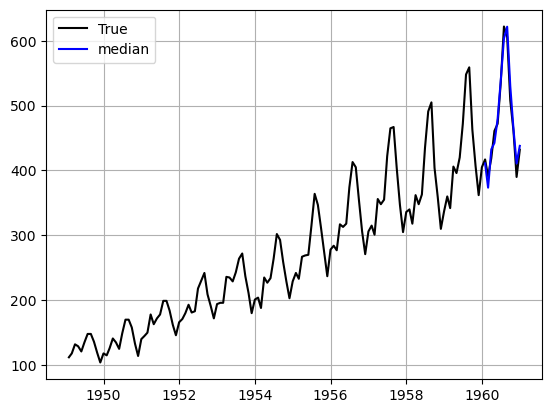

In [10]:
#| eval: false
# Plot
plot_df = Y_test_df.copy()
plot_df['DeepAR'] = forecasts.reset_index(drop=False)['DeepAR']
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['DeepAR'], c='blue', label='median')
plt.grid()
plt.legend()
plt.plot()